# Computing the nonadiabatic couplings in Kohn-Sham and excited states bases in extended tight-binding framework

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/2_xTB). The NACs will be computed in Kohn-Sham states but only in single-partcile (SP) excited state basis, not many-body (MB) states, because we did not perform TD-DFT. Finally we will plot the excited states energies vs time and NAC map.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Computing the NACs](#comp_nacs)     
    3.1. [Kohn-Sham basis](#KS)\
    3.2. [Excited state basis](#excited_states)
4. [Plotting the results](#plotting)\
    4.1. [NAC distribution](#nac_dist)\
    4.2. [Energy vs time](#ene_time)\
    4.3. [NAC map](#nac_map)

### A. Learning objectives

* To be able to compute the NACs in Kohn-Sham and excited state basis
* To be able to plot the NACs distribution 
* To be able to plot the computed excited states energies vs time
* To be able to plot the NAC map

### B. Use cases

* [Computing the NACs](#comp_nacs)
* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    -  `cmat_distrib`
  - `workflows`
    - `nbra`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read and check the orthonormality of the data.
Import `numpy`, `scipy.sparse`, `data_stat`, `data_io`, `units`, and `step3` modules. Also, `glob` will be needed to find specific types of files.

In [1]:
import os
import sys
import time
import glob
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3
from libra_py import units, data_stat, data_io

/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/import

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

* `../../7_step2_cp2k/1_xTB/2_hpc/res`

The MO overlap files are needed and stored in this folder.

* `../../7_step2_cp2k/1_xTB/2_hpc/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index. 

## 3. Computing the NACs <a name="comp_nacs"></a>
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbital 
overlaps. The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and energy matrices.

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.

`params['apply_phase_correction']`: A boolean flag for applying phase-correction algorithm.

`params['apply_orthonormalization']`: A boolean flag for applying the orthonormalization algorithm.

`params['do_state_reordering']`: If this value is set to `1` or `2`, the state-reordering will be applied to overlap matrices.

`params['state_reordering_alpha']`: The state-reordering alpha value if the `params['do_state_reordering'] = 2`.

After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.

In [3]:
params_ks = {
          'lowest_orbital': 128-20, 'highest_orbital': 128+21, 'num_occ_states': 20, 'num_unocc_states': 20,
          'use_multiprocessing': True, 'nprocs': 4, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_logfiles',
          'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks',
          'start_time': 1, 'finish_time': 149,
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }

#### For KS states - Applying correction to KS overlaps and computing the NACs in KS space
step3.run_step3_ks_nacs_libint(params_ks)

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step  111

Computing orthonormalization of St matrices in step 21
Computing orthonormalization of St matrices in step 31
Done with step 31 . Elapsed time: 0.46163105964660645Done with step
Computing orthonormalization of St matrices in step  321
 . Elapsed time: 0.4902346134185791
Computing orthonormalization of St matrices in step Done with step2 
11Done with step  . Elapsed time:Done with step 21  0.59518194198608432. Elapsed time:
  0.627845048904419Computing orthonormalization of St matrices in step. Elapsed time:
 Computing orthonormalization of St matrices in step12  22
0.16163229942321777

Computing orthonormalization of St matrices in step 33
Done with step 2 . Elapsed time: 0.21499896049499512
Computing orthonormalization of St matrices in step 3
Done with step Done with step12Done with step   33 . Elapsed time:Done with step. Elapsed time: 3  22  0.2668609619140625
. Elapsed time

0.2655198574066162. Elapsed time:0.2353649139404297Computing orthonormalization of St matrices in step
 
 Computing orthonormalization of St matrices in step69 Computing orthonormalization of St matrices in step0.26845479011535645 8179


Computing orthonormalization of St matrices in step 91

Done with stepDone with step  7991  . Elapsed time:Done with step. Elapsed time: 0.2115473747253418  69Done with step
0.22359061241149902Computing orthonormalization of St matrices in step  
 81. Elapsed time:Computing orthonormalization of St matrices in step92  
 . Elapsed time:0.3166100978851318480

 0.3085296154022217
Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step  7082

Done with step Done with step80  92. Elapsed time:  . Elapsed time:0.2258758544921875Done with step 
 0.27284789085388184Computing orthonormalization of St matrices in step
82  Computing orthonormalization of St matrices in step . Elapsed time:93
101 
0.2699737548828125
C

Applying phase-correction to step 2
Applying phase-correction to step 3
Applying phase-correction to step 4
Applying phase-correction to step 5
Applying phase-correction to step 6
Applying phase-correction to step 7
Applying phase-correction to step 8
Applying phase-correction to step 9
Applying phase-correction to step 10
Applying phase-correction to step 11
Applying phase-correction to step 12
Applying phase-correction to step 13
Applying phase-correction to step 14
Applying phase-correction to step 15
Applying phase-correction to step 16
Applying phase-correction to step 17
Applying phase-correction to step 18
Applying phase-correction to step 19
Applying phase-correction to step 20
Applying phase-correction to step 21
Applying phase-correction to step 22
Applying phase-correction to step 23
Applying phase-correction to step 24
Applying phase-correction to step 25
Applying phase-correction to step 26
Applying phase-correction to step 27
Applying phase-correction to step 28
Applying 

### 3.2. Excited state basis <a name="excited_states"></a>

The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will also be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

To run the calculations `step3.run_step3_sd_nacs_libint(params)` function will be used. Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)`.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 



Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT is performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.




In [4]:
#### For excited states - Computing the excited states SDs and their overlaps and NACs
params_mb_sd = {
          'lowest_orbital': 128-20, 'highest_orbital': 128+21, 'num_occ_states': 20, 'num_unocc_states': 20,
          'isUKS': 0, 'number_of_states': 0, 'tolerance': 0.01, 'verbosity': 0,
          'use_multiprocessing': True, 'nprocs': 4,
          'is_many_body': False, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis',
          'outdir': os.getcwd()+'/res-mixed-basis',
          'start_time': 1, 'finish_time': 149, 'sorting_type': 'identity',
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }


step3.run_step3_sd_nacs_libint(params_mb_sd)

sd_unique_basis is: [[[20, 21], 'alp'], [[20, 22], 'alp'], [[20, 23], 'alp'], [[20, 24], 'alp'], [[20, 25], 'alp'], [[20, 26], 'alp'], [[20, 27], 'alp'], [[20, 28], 'alp'], [[20, 29], 'alp'], [[20, 30], 'alp'], [[20, 31], 'alp'], [[20, 32], 'alp'], [[20, 33], 'alp'], [[20, 34], 'alp'], [[20, 35], 'alp'], [[20, 36], 'alp'], [[20, 37], 'alp'], [[20, 38], 'alp'], [[20, 39], 'alp'], [[20, 40], 'alp'], [[1, 21], 'alp'], [[2, 21], 'alp'], [[3, 21], 'alp'], [[4, 21], 'alp'], [[5, 21], 'alp'], [[6, 21], 'alp'], [[7, 21], 'alp'], [[8, 21], 'alp'], [[9, 21], 'alp'], [[10, 21], 'alp'], [[11, 21], 'alp'], [[12, 21], 'alp'], [[13, 21], 'alp'], [[14, 21], 'alp'], [[15, 21], 'alp'], [[16, 21], 'alp'], [[17, 21], 'alp'], [[18, 21], 'alp'], [[19, 21], 'alp']]
sd_states_reindexed is: [[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 19, -19, 20, -20], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9

Computing the SD overlaps for step 1
Done with computing the SD overlap of step 20. Elapsed time 0.45174264907836914
Computing the SD overlaps for step 21
Applying orthonormalization for SDs for step 11
Applying orthonormalization for SDs for step 1
Done with computing the SD overlap of step 1. Elapsed time 0.23198342323303223Done with computing the SD overlap of step 11. Elapsed time 0.36664867401123047
Applying orthonormalization for SDs for stepComputing the SD overlaps for step
  1221Computing the SD overlaps for step

 Applying orthonormalization for SDs for stepDone with computing the SD overlap of step 21. Elapsed time 0.2492973804473877
Computing the SD overlaps for step2
  22
31
Done with computing the SD overlap of step 31. Elapsed time 0.3416557312011719
Computing the SD overlaps for step 32
Applying orthonormalization for SDs for step 22
Done with computing the SD overlap of step 22. Elapsed time 0.21332478523254395
Computing the SD overlaps for step 23
Applying orthonormal

Computing the SD overlaps for step Done with computing the SD overlap of step 53. Elapsed time 0.332460641860961944

Computing the SD overlaps for step 54
Applying orthonormalization for SDs for step 72
Done with computing the SD overlap of step 72. Elapsed time 0.3150627613067627
Computing the SD overlaps for step 73
Applying orthonormalization for SDs for step 63
Done with computing the SD overlap of step 63. Elapsed time 0.2924797534942627
Computing the SD overlaps for step 64Applying orthonormalization for SDs for step
 54
Applying orthonormalization for SDs for stepDone with computing the SD overlap of step 54. Elapsed time 0.32294774055480957 
44Computing the SD overlaps for step
 55
Done with computing the SD overlap of step 44. Elapsed time 0.3656959533691406
Computing the SD overlaps for step 45
Applying orthonormalization for SDs for step 73
Done with computing the SD overlap of step 73. Elapsed time 0.31499648094177246
Computing the SD overlaps for step 74
Applying orthonorm

 106Done with computing the SD overlap of step 95. Elapsed time 0.32055187225341797

Computing the SD overlaps for step 96
Applying orthonormalization for SDs for step 85
Done with computing the SD overlap of step 85. Elapsed time 0.2578721046447754
Computing the SD overlaps for step 86
Applying orthonormalization for SDs for step 115
Done with computing the SD overlap of step 115. Elapsed time 0.3975026607513428
Computing the SD overlaps for step 116
Applying orthonormalization for SDs for step 106
Applying orthonormalization for SDs for stepDone with computing the SD overlap of step 106. Elapsed time 0.29851746559143066 96

Computing the SD overlaps for stepDone with computing the SD overlap of step 96. Elapsed time 0.32387351989746094Applying orthonormalization for SDs for step 
 107Computing the SD overlaps for step86 

97Done with computing the SD overlap of step 86. Elapsed time 0.2598075866699219

Computing the SD overlaps for step 87
Applying orthonormalization for SDs for step

## 4. Plotting the results <a name='plotting'></a>
[Back to TOC](#toc)

### 4.1. NAC distribution <a name='nac_dist'></a>

One of the intuitive ways to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states.

<IPython.core.display.Javascript object>


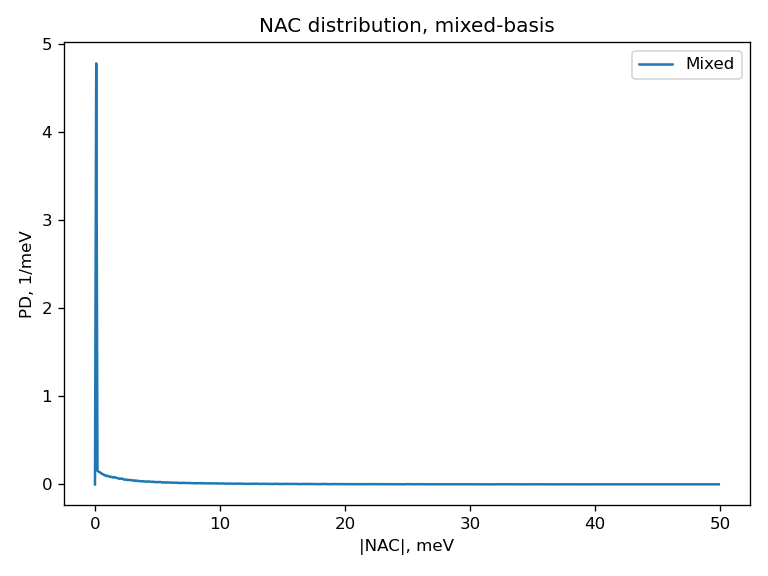

In [5]:
%matplotlib notebook

for basis in ['sd']:
    nac = []
    nac_files = glob.glob(F'res-mixed-basis/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp, dens, label='Mixed')
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution, mixed-basis')
plt.legend()
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)

### 4.2. Energy vs time <a name='ene_time'></a>
Here, we plot the excited states energy vs time. Since the excited states were sorted by their `'identity'` it is easy to visualize the states energies crossings.

Sorted energy files are: ['res-mixed-basis/Hvib_sd_1_re.npz', 'res-mixed-basis/Hvib_sd_2_re.npz', 'res-mixed-basis/Hvib_sd_3_re.npz', 'res-mixed-basis/Hvib_sd_4_re.npz', 'res-mixed-basis/Hvib_sd_5_re.npz', 'res-mixed-basis/Hvib_sd_6_re.npz', 'res-mixed-basis/Hvib_sd_7_re.npz', 'res-mixed-basis/Hvib_sd_8_re.npz', 'res-mixed-basis/Hvib_sd_9_re.npz', 'res-mixed-basis/Hvib_sd_10_re.npz', 'res-mixed-basis/Hvib_sd_11_re.npz', 'res-mixed-basis/Hvib_sd_12_re.npz', 'res-mixed-basis/Hvib_sd_13_re.npz', 'res-mixed-basis/Hvib_sd_14_re.npz', 'res-mixed-basis/Hvib_sd_15_re.npz', 'res-mixed-basis/Hvib_sd_16_re.npz', 'res-mixed-basis/Hvib_sd_17_re.npz', 'res-mixed-basis/Hvib_sd_18_re.npz', 'res-mixed-basis/Hvib_sd_19_re.npz', 'res-mixed-basis/Hvib_sd_20_re.npz', 'res-mixed-basis/Hvib_sd_21_re.npz', 'res-mixed-basis/Hvib_sd_22_re.npz', 'res-mixed-basis/Hvib_sd_23_re.npz', 'res-mixed-basis/Hvib_sd_24_re.npz', 'res-mixed-basis/Hvib_sd_25_re.npz', 'res-mixed-basis/Hvib_sd_26_re.npz', 'res-mixed-basis/Hvib

<IPython.core.display.Javascript object>


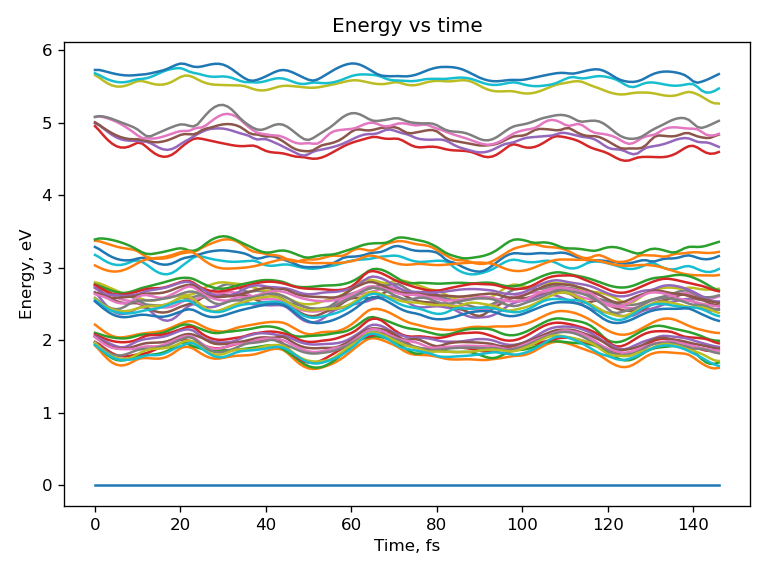

In [6]:
%matplotlib notebook
energy_files = glob.glob('res-mixed-basis/Hvib_sd*re*')
energy_files = data_io.sort_hvib_file_names(energy_files)
print('Sorted energy files are:', energy_files)
dt = 1.0 # fs
energies = []
for file in energy_files:
    energies.append(np.diag(sp.load_npz(file).todense().real))
energies = np.array(energies)*units.au2ev
md_time = np.arange(0,energies.shape[0]*dt,dt)
print(energies.shape)
for i in range(energies.shape[1]):
    plt.plot(md_time, energies[:,i]-energies[:,0])
plt.title('Energy vs time')
plt.ylabel('Energy, eV')
plt.xlabel('Time, fs')
plt.tight_layout()

### 4.3. NAC map <a name='nac_map'></a>
Another way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


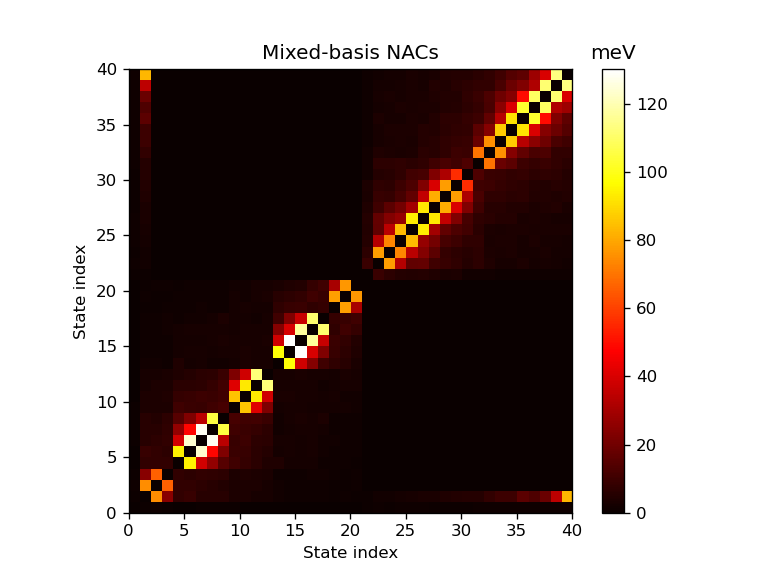

Text(0.5, 1.0, 'Mixed-basis NACs')

In [10]:
%matplotlib notebook
nac_files = glob.glob('res-mixed-basis/Hvib_sd*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=150)
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar().ax.set_title('meV')
plt.title('Mixed-basis NACs')